Based on the previous model build with LightGBM, an expansion of the framework is proposed, this time with a target on European financial market, to be more precise our target variable is the Dutch TTF, which is a virtual trading point for the natural gas in the netherlands but also acts as a primary benchmark for European gas prices. By evaluating how the gas price fluctuate over time we can build a more better performing engine to estimate patters of gas demand with the adition on features of financial nature and also incorporating a more novel metodology, the utilisation of GHD in the build up of those following engineered features.

One of the features was build using the variance estimates from an EGARCH(1,1) model with mean specification ARMA(1,1) build upon log-returns of the Dutch TTF daily values over a period of 1867 observations. Spanning from 2017-10-23 to 2025-03-27.

In [ ]:
# Data processing --Disclaimer: Install every library (skforecast, matplotlib etc.)
# ==============================================================================
import numpy as np
import pandas as pd
import yfinance as yf
import time
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
import lightgbm
import skforecast
import sklearn
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
from skforecast.plot import plot_prediction_intervals
from skforecast.preprocessing import RollingFeatures
from sklearn.metrics import mean_absolute_error
import shap
import eurostat

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
warnings.simplefilter(action='ignore', category=FutureWarning)

color = '\033[1m\033[38;5;208m'
print(f"{color}Version skforecast: {skforecast.__version__}")
print(f"{color}Version scikit-learn: {sklearn.__version__}")
print(f"{color}Version lightgbm: {lightgbm.__version__}")
print(f"{color}Version pandas: {pd.__version__}")
print(f"{color}Version numpy: {np.__version__}")

c:\Users\const\anaconda3\envs\lightgbm-icbe2025\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Version skforecast: 0.15.0
Version scikit-learn: 1.6.1
Version lightgbm: 4.6.0
Version pandas: 2.2.3
Version numpy: 2.1.3


Extracting Dutch TTF from Yahoo Finance using the yFinance API

In [ ]:
min_date='2017-10-23'
max_date='2025-02-27'


[*********************100%***********************]  2 of 2 completed

1 Failed download:
['^DXY']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-10-23 -> 2025-02-27)')
c:\Users\const\anaconda3\envs\lightgbm-icbe2025\Lib\site-packages\pandas\core\arrays\datetimelike.py:460: ResourceWarning:

unclosed database in <sqlite3.Connection object at 0x000001C2EB7F1030>

c:\Users\const\anaconda3\envs\lightgbm-icbe2025\Lib\site-packages\pandas\core\arrays\datetimelike.py:460: ResourceWarning:

unclosed database in <sqlite3.Connection object at 0x000001C2EB7F1120>



In [3]:
# Add delay and error handling for Yahoo Finance requests
def get_yahoo_finance_data(symbol, start_date, end_date, max_retries=5, delay=2):
    for attempt in range(max_retries):
        try:
            ticker = yf.Ticker(symbol)
            ticker_data = ticker.history(start=start_date, end=end_date)
            return ticker_data
        except Exception as e:
            if 'Too Many Requests' in str(e):
                print(f"Rate limit hit, waiting {delay} seconds before retry. Attempt {attempt + 1}/{max_retries}")
                time.sleep(delay)
                delay *= 2  # Exponential backoff
            else:
                raise e
    raise Exception("Max retries reached, could not fetch data")

# Use the new function instead of direct yfinance call
ticker_symbol = 'TTF=F'

ticker_data = get_yahoo_finance_data(ticker_symbol, '2017-10-23', '2025-02-27')

ttf = ticker_data.drop(columns=['Dividends', 'Stock Splits', 'Volume'])
ttf.head(15)


Open       High        Low      Close
Date                                                                 
2017-10-23 00:00:00-04:00  18.090000  18.090000  18.090000  18.090000
2017-10-24 00:00:00-04:00  17.959999  17.959999  17.959999  17.959999
2017-10-25 00:00:00-04:00  18.110001  18.110001  18.110001  18.110001
2017-10-26 00:00:00-04:00  18.070000  18.070000  18.070000  18.070000
2017-10-27 00:00:00-04:00  18.150000  18.150000  18.150000  18.150000
2017-10-30 00:00:00-04:00  18.110001  18.110001  18.110001  18.110001
2017-10-31 00:00:00-04:00  18.285000  18.285000  18.285000  18.285000
2017-11-01 00:00:00-04:00  18.549999  18.549999  18.549999  18.549999
2017-11-02 00:00:00-04:00  18.580000  18.580000  18.580000  18.580000
2017-11-03 00:00:00-04:00  18.309999  18.309999  18.309999  18.309999
2017-11-06 00:00:00-05:00  19.010000  19.010000  19.010000  19.010000
2017-11-07 00:00:00-05:00  19.325001  19.325001  19.325001  19.325001
2017-11-08 00:00:00-05:00  19.379999  19.379999  19.379999  19.379999
2017-11-09 00:00:00-05:00  19.514999  19.514999  19.514999  19.514999
2017-11-10 00:00:00-05:00  19.820000  19.820000  19.820000  19.820000

In [31]:
print(ttf.isna().sum()) # No missing valuess
print(ttf.shape) #

Open     0
High     0
Low      0
Close    0
dtype: int64
(1847, 4)


In [32]:
garch_ghp = pd.read_csv('jointedTTF.csv', parse_dates=[0])

garch_ghp.set_index('Unnamed: 0', inplace=True)
garch_ghp.index.name = "Date"
garch_ghp.head(10)

daily.returns        var     sigma     resid Model
Date                                                          
2017-10-24      -0.718635  28.151047  5.305756 -0.718635  Fit1
2017-10-25       0.835198  23.828397  4.881434  0.894933  Fit1
2017-10-26      -0.220877  20.287256  4.504138 -0.314371  Fit1
2017-10-27       0.442722  17.228617  4.150737  0.498755  Fit1
2017-10-30      -0.220380  14.714300  3.835922 -0.279758  Fit1
2017-10-31       0.966313  12.597895  3.549351  1.008557  Fit1
2017-11-01       1.449272  10.998989  3.316472  1.351927  Fit1
2017-11-02       0.161729   9.808111  3.131790  0.080486  Fit1
2017-11-03      -1.453178   8.512153  2.917559 -1.433885  Fit1
2017-11-06       3.823052   7.781785  2.789585  3.936070  Fit1

In [33]:
ttf.head(10)

Open       High        Low      Close
Date                                                                 
2017-10-23 00:00:00-04:00  18.090000  18.090000  18.090000  18.090000
2017-10-24 00:00:00-04:00  17.959999  17.959999  17.959999  17.959999
2017-10-25 00:00:00-04:00  18.110001  18.110001  18.110001  18.110001
2017-10-26 00:00:00-04:00  18.070000  18.070000  18.070000  18.070000
2017-10-27 00:00:00-04:00  18.150000  18.150000  18.150000  18.150000
2017-10-30 00:00:00-04:00  18.110001  18.110001  18.110001  18.110001
2017-10-31 00:00:00-04:00  18.285000  18.285000  18.285000  18.285000
2017-11-01 00:00:00-04:00  18.549999  18.549999  18.549999  18.549999
2017-11-02 00:00:00-04:00  18.580000  18.580000  18.580000  18.580000
2017-11-03 00:00:00-04:00  18.309999  18.309999  18.309999  18.309999

In [34]:
print(garch_ghp.isna().sum())
print(garch_ghp.shape)

daily.returns    0
var              0
sigma            0
resid            0
Model            0
dtype: int64
(1867, 5)


In [35]:
ttf_normalized = ttf.tz_localize(None)
ttf_normalized.head()

Open       High        Low      Close
Date                                                  
2017-10-23  18.090000  18.090000  18.090000  18.090000
2017-10-24  17.959999  17.959999  17.959999  17.959999
2017-10-25  18.110001  18.110001  18.110001  18.110001
2017-10-26  18.070000  18.070000  18.070000  18.070000
2017-10-27  18.150000  18.150000  18.150000  18.150000

In [36]:
garch_ghp_normalize = garch_ghp.tz_localize(None)
garch_ghp_normalize.head()

daily.returns        var     sigma     resid Model
Date                                                          
2017-10-24      -0.718635  28.151047  5.305756 -0.718635  Fit1
2017-10-25       0.835198  23.828397  4.881434  0.894933  Fit1
2017-10-26      -0.220877  20.287256  4.504138 -0.314371  Fit1
2017-10-27       0.442722  17.228617  4.150737  0.498755  Fit1
2017-10-30      -0.220380  14.714300  3.835922 -0.279758  Fit1

In [37]:
ttf.head()

Open       High        Low      Close
Date                                                                 
2017-10-23 00:00:00-04:00  18.090000  18.090000  18.090000  18.090000
2017-10-24 00:00:00-04:00  17.959999  17.959999  17.959999  17.959999
2017-10-25 00:00:00-04:00  18.110001  18.110001  18.110001  18.110001
2017-10-26 00:00:00-04:00  18.070000  18.070000  18.070000  18.070000
2017-10-27 00:00:00-04:00  18.150000  18.150000  18.150000  18.150000

In [38]:
#Matchin the dates for the values

# Joining based on the normalized date index
data = ttf_normalized.join(garch_ghp_normalize, how="inner")

data.head(10)

Open       High        Low      Close  daily.returns  \
Date                                                                    
2017-10-24  17.959999  17.959999  17.959999  17.959999      -0.718635   
2017-10-25  18.110001  18.110001  18.110001  18.110001       0.835198   
2017-10-26  18.070000  18.070000  18.070000  18.070000      -0.220877   
2017-10-27  18.150000  18.150000  18.150000  18.150000       0.442722   
2017-10-30  18.110001  18.110001  18.110001  18.110001      -0.220380   
2017-10-31  18.285000  18.285000  18.285000  18.285000       0.966313   
2017-11-01  18.549999  18.549999  18.549999  18.549999       1.449272   
2017-11-02  18.580000  18.580000  18.580000  18.580000       0.161729   
2017-11-03  18.309999  18.309999  18.309999  18.309999      -1.453178   
2017-11-06  19.010000  19.010000  19.010000  19.010000       3.823052   

                  var     sigma     resid Model  
Date                                             
2017-10-24  28.151047  5.305756 -0.718635  Fit1  
2017-10-25  23.828397  4.881434  0.894933  Fit1  
2017-10-26  20.287256  4.504138 -0.314371  Fit1  
2017-10-27  17.228617  4.150737  0.498755  Fit1  
2017-10-30  14.714300  3.835922 -0.279758  Fit1  
2017-10-31  12.597895  3.549351  1.008557  Fit1  
2017-11-01  10.998989  3.316472  1.351927  Fit1  
2017-11-02   9.808111  3.131790  0.080486  Fit1  
2017-11-03   8.512153  2.917559 -1.433885  Fit1  
2017-11-06   7.781785  2.789585  3.936070  Fit1

Generating more features. For the first set of engineered feature we can implement Date/Time feature, thus analyzing if specific days, month, quarters or even years have a semnificative impact on the data set.


In [39]:
# Implementation of calendaristic features
data['dayofweek'] = data.index.dayofweek # Monday=0, Sunday=6
data['dayofmonth'] = data.index.day # From 1 to 31
data['dayofyear'] = data.index.dayofyear # 1 to 365
data['weekofyear'] = data.index.isocalendar().week.astype(int)
data['month'] = data.index.month
data['quarter'] = data.index.quarter
data['year'] = data.index.year


In [40]:
data.head(15)

Open       High        Low      Close  daily.returns  \
Date                                                                    
2017-10-24  17.959999  17.959999  17.959999  17.959999      -0.718635   
2017-10-25  18.110001  18.110001  18.110001  18.110001       0.835198   
2017-10-26  18.070000  18.070000  18.070000  18.070000      -0.220877   
2017-10-27  18.150000  18.150000  18.150000  18.150000       0.442722   
2017-10-30  18.110001  18.110001  18.110001  18.110001      -0.220380   
2017-10-31  18.285000  18.285000  18.285000  18.285000       0.966313   
2017-11-01  18.549999  18.549999  18.549999  18.549999       1.449272   
2017-11-02  18.580000  18.580000  18.580000  18.580000       0.161729   
2017-11-03  18.309999  18.309999  18.309999  18.309999      -1.453178   
2017-11-06  19.010000  19.010000  19.010000  19.010000       3.823052   
2017-11-07  19.325001  19.325001  19.325001  19.325001       1.657025   
2017-11-08  19.379999  19.379999  19.379999  19.379999       0.284597   
2017-11-09  19.514999  19.514999  19.514999  19.514999       0.696596   
2017-11-10  19.820000  19.820000  19.820000  19.820000       1.562902   
2017-11-13  19.905001  19.905001  19.905001  19.905001       0.428865   

                  var     sigma     resid Model  dayofweek  dayofmonth  \
Date                                                                     
2017-10-24  28.151047  5.305756 -0.718635  Fit1          1          24   
2017-10-25  23.828397  4.881434  0.894933  Fit1          2          25   
2017-10-26  20.287256  4.504138 -0.314371  Fit1          3          26   
2017-10-27  17.228617  4.150737  0.498755  Fit1          4          27   
2017-10-30  14.714300  3.835922 -0.279758  Fit1          0          30   
2017-10-31  12.597895  3.549351  1.008557  Fit1          1          31   
2017-11-01  10.998989  3.316472  1.351927  Fit1          2           1   
2017-11-02   9.808111  3.131790  0.080486  Fit1          3           2   
2017-11-03   8.512153  2.917559 -1.433885  Fit1          4           3   
2017-11-06   7.781785  2.789585  3.936070  Fit1          0           6   
2017-11-07   9.441557  3.072712  1.293703  Fit1          1           7   
2017-11-08   8.488987  2.913587  0.293259  Fit1          2           8   
2017-11-09   7.430289  2.725856  0.669449  Fit1          3           9   
2017-11-10   6.612329  2.571445  1.515938  Fit1          4          10   
2017-11-13   6.245174  2.499035  0.317876  Fit1          0          13   

            dayofyear  weekofyear  month  quarter  year  
Date                                                     
2017-10-24        297          43     10        4  2017  
2017-10-25        298          43     10        4  2017  
2017-10-26        299          43     10        4  2017  
2017-10-27        300          43     10        4  2017  
2017-10-30        303          44     10        4  2017  
2017-10-31        304          44     10        4  2017  
2017-11-01        305          44     11        4  2017  
2017-11-02        306          44     11        4  2017  
2017-11-03        307          44     11        4  2017  
2017-11-06        310          45     11        4  2017  
2017-11-07        311          45     11        4  2017  
2017-11-08        312          45     11        4  2017  
2017-11-09        313          45     11        4  2017  
2017-11-10        314          45     11        4  2017  
2017-11-13        317          46     11        4  2017

In [41]:
# Computing fourier transformations

from sklearn.preprocessing import FunctionTransformer

def sin_transformer(periods):
    return FunctionTransformer(lambda x: np.sin(x / periods * 2 * np.pi))

def cos_transformer(periods):
    return FunctionTransformer(lambda x: np.cos(x / periods * 2 * np.pi))

In [42]:
# We will apply fourier transformation to day of the week, and months
data['week_sin']  = sin_transformer(7).fit_transform(data['dayofweek'])
data['week_cos']  = cos_transformer(7).fit_transform(data['dayofweek'])
data['month_sin'] = sin_transformer(12).fit_transform(data['month'])
data['month_cos'] = cos_transformer(12).fit_transform(data['month'])
data['quarter_sin'] = sin_transformer(4).fit_transform(data['quarter'])
data['quarter_cos'] = cos_transformer(4).fit_transform(data['quarter'])

In [43]:
data.head(15)

Open       High        Low      Close  daily.returns  \
Date                                                                    
2017-10-24  17.959999  17.959999  17.959999  17.959999      -0.718635   
2017-10-25  18.110001  18.110001  18.110001  18.110001       0.835198   
2017-10-26  18.070000  18.070000  18.070000  18.070000      -0.220877   
2017-10-27  18.150000  18.150000  18.150000  18.150000       0.442722   
2017-10-30  18.110001  18.110001  18.110001  18.110001      -0.220380   
2017-10-31  18.285000  18.285000  18.285000  18.285000       0.966313   
2017-11-01  18.549999  18.549999  18.549999  18.549999       1.449272   
2017-11-02  18.580000  18.580000  18.580000  18.580000       0.161729   
2017-11-03  18.309999  18.309999  18.309999  18.309999      -1.453178   
2017-11-06  19.010000  19.010000  19.010000  19.010000       3.823052   
2017-11-07  19.325001  19.325001  19.325001  19.325001       1.657025   
2017-11-08  19.379999  19.379999  19.379999  19.379999       0.284597   
2017-11-09  19.514999  19.514999  19.514999  19.514999       0.696596   
2017-11-10  19.820000  19.820000  19.820000  19.820000       1.562902   
2017-11-13  19.905001  19.905001  19.905001  19.905001       0.428865   

                  var     sigma     resid Model  dayofweek  ...  weekofyear  \
Date                                                        ...               
2017-10-24  28.151047  5.305756 -0.718635  Fit1          1  ...          43   
2017-10-25  23.828397  4.881434  0.894933  Fit1          2  ...          43   
2017-10-26  20.287256  4.504138 -0.314371  Fit1          3  ...          43   
2017-10-27  17.228617  4.150737  0.498755  Fit1          4  ...          43   
2017-10-30  14.714300  3.835922 -0.279758  Fit1          0  ...          44   
2017-10-31  12.597895  3.549351  1.008557  Fit1          1  ...          44   
2017-11-01  10.998989  3.316472  1.351927  Fit1          2  ...          44   
2017-11-02   9.808111  3.131790  0.080486  Fit1          3  ...          44   
2017-11-03   8.512153  2.917559 -1.433885  Fit1          4  ...          44   
2017-11-06   7.781785  2.789585  3.936070  Fit1          0  ...          45   
2017-11-07   9.441557  3.072712  1.293703  Fit1          1  ...          45   
2017-11-08   8.488987  2.913587  0.293259  Fit1          2  ...          45   
2017-11-09   7.430289  2.725856  0.669449  Fit1          3  ...          45   
2017-11-10   6.612329  2.571445  1.515938  Fit1          4  ...          45   
2017-11-13   6.245174  2.499035  0.317876  Fit1          0  ...          46   

            month  quarter  year  week_sin  week_cos  month_sin  month_cos  \
Date                                                                         
2017-10-24     10        4  2017  0.781831  0.623490  -0.866025   0.500000   
2017-10-25     10        4  2017  0.974928 -0.222521  -0.866025   0.500000   
2017-10-26     10        4  2017  0.433884 -0.900969  -0.866025   0.500000   
2017-10-27     10        4  2017 -0.433884 -0.900969  -0.866025   0.500000   
2017-10-30     10        4  2017  0.000000  1.000000  -0.866025   0.500000   
2017-10-31     10        4  2017  0.781831  0.623490  -0.866025   0.500000   
2017-11-01     11        4  2017  0.974928 -0.222521  -0.500000   0.866025   
2017-11-02     11        4  2017  0.433884 -0.900969  -0.500000   0.866025   
2017-11-03     11        4  2017 -0.433884 -0.900969  -0.500000   0.866025   
2017-11-06     11        4  2017  0.000000  1.000000  -0.500000   0.866025   
2017-11-07     11        4  2017  0.781831  0.623490  -0.500000   0.866025   
2017-11-08     11        4  2017  0.974928 -0.222521  -0.500000   0.866025   
2017-11-09     11        4  2017  0.433884 -0.900969  -0.500000   0.866025   
2017-11-10     11        4  2017 -0.433884 -0.900969  -0.500000   0.866025   
2017-11-13     11        4  2017  0.000000  1.000000  -0.500000   0.866025   

             quarter_sin  quarter_cos  
Date                                   
2017-10-24 -2.449294e-16

Intraday change features OPEN-CLOSE change and HIGH-LOW range.

In [44]:
data["OC_change"] = data["Open"] - data["Close"]
data["HL_range"]  = data["High"] - data["Low"]

In [45]:
data.tail(50)

Open       High        Low      Close  daily.returns  \
Date                                                                    
2024-12-13  42.540001  43.244999  41.009998  41.215000      -3.712271   
2024-12-16  40.185001  40.584999  38.955002  40.277000      -2.275870   
2024-12-17  40.500000  42.145000  39.955002  42.064999       4.439254   
2024-12-18  42.355000  42.400002  40.630001  41.007000      -2.515152   
2024-12-19  41.474998  43.615002  39.834999  43.077999       5.050355   
2024-12-20  43.875000  44.465000  42.785000  44.130001       2.442086   
2024-12-23  44.334999  45.834999  43.799999  45.544998       3.206429   
2024-12-24  45.750000  46.549999  45.299999  45.730999       0.408389   
2024-12-26  45.730999  45.730999  45.730999  45.730999       0.000000   
2024-12-27  47.180000  47.930000  46.799999  47.730999       4.373401   
2024-12-30  48.299999  48.299999  47.235001  47.632999      -0.205316   
2024-12-31  48.349998  50.529999  48.224998  48.889000       2.636829   
2025-01-02  50.215000  50.695000  48.615002  50.272999       2.830900   
2025-01-03  49.904999  50.349998  49.384998  49.622002      -1.294924   
2025-01-06  49.099998  49.250000  46.939999  47.326000      -4.626983   
2025-01-07  46.750000  47.860001  45.985001  47.473999       0.312722   
2025-01-08  47.994999  47.994999  45.139999  45.558998      -4.033789   
2025-01-09  45.095001  45.480000  43.895000  44.987000      -1.255512   
2025-01-10  44.849998  45.785000  43.224998  45.007999       0.046680   
2025-01-13  46.650002  48.570000  46.650002  48.261002       7.227609   
2025-01-14  48.529999  48.605000  46.605000  46.946999      -2.722701   
2025-01-15  47.450001  47.750000  46.450001  47.006001       0.125678   
2025-01-16  46.205002  46.410000  45.700001  46.241001      -1.627450   
2025-01-17  46.000000  47.404999  45.764999  46.887001       1.397028   
2025-01-21  46.650002  50.224998  46.150002  50.027000       6.696951   
2025-01-22  50.084999  50.700001  48.549999  48.716000      -2.620587   
2025-01-23  48.830002  50.299999  48.599998  49.123001       0.835458   
2025-01-24  49.584999  49.910000  48.205002  49.702000       1.178671   
2025-01-27  48.825001  48.900002  47.830002  47.862000      -3.702065   
2025-01-28  48.200001  48.615002  48.049999  48.223999       0.756340   
2025-01-29  49.740002  51.330002  49.740002  51.155998       6.079959   
2025-01-30  52.020000  52.540001  51.529999  51.726002       1.114246   
2025-01-31  52.000000  53.755001  51.945000  53.237000       2.921157   
2025-02-03  54.200001  54.619999  52.849998  53.793999       1.046263   
2025-02-04  52.904999  53.395000  51.389999  52.048000      -3.245712   
2025-02-05  51.849998  53.904999  51.849998  53.438000       2.670611   
2025-02-06  53.910000  55.465000  53.549999  54.501999       1.991091   
2025-02-07  53.814999  56.049999  53.660000  55.723000       2.240286   
2025-02-10  57.299999  58.695000  57.255001  58.039001       4.156276   
2025-02-11  57.130001  59.334999  56.375000  57.765999      -0.470378   
2025-02-12  56.200001  57.000000  54.230000  55.660999      -3.644011   
2025-02-13  55.660000  55.660000  50.564999  51.382999      -7.685812   
2025-02-14  50.049999  51.599998  48.389999  50.685001      -1.358422   
2025-02-18  50.005001  50.895000  46.840000  49.215000      -2.900269   
2025-02-19  50.000000  50.395000  47.119999  48.264000      -1.932338   
2025-02-20  47.349998  48.599998  47.064999  47.493999      -1.595393   
2025-02-21  47.650002  48.224998  46.105000  47.195000      -0.629553   
2025-02-24  46.134998  47.259998  45.110001  47.144001      -0.108060   
2025-02-25  45.435001  45.834999  43.750000  44.291000      -6.051673   
2025-02-26  41.335999  41.335999  41.335999  41.335999      -6.671788   

                  var     sigma     resid Model  dayofweek  ...  quarter  \
Date                                                        ...            
2024-12-13   9.067568  3.011240 -3.769326  Fit2          4  ...     

Next we compute other rolling windows variables for closing price, like mean, standard deviation, maximum and minimum values in a month and lagged closing prices.

Setting up the train - validate - test split

In [46]:
def train_val_test_split(df, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=False, random_state=None):
    """
    Imparte un DataFrame in seturi de antrenament, validare si testare.
    Argumente:
        df (pd.DataFrame): DataFrame-ul de impartit.
        train_size (float): Proportia pentru setul de antrenament.
        val_size (float): Proportia pentru setul de validare.
        test_size (float): Proportia pentru setul de testare.
        shuffle (bool): Daca se amesteca inainte de impartire.
        random_state (int, optional): Seed pentru reproductibilitate.
    Returneaza:
        (train_df, val_df, test_df): Tuplu de DataFrame-uri.
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Splits must sum to 1.0"
    n = len(df)
    if shuffle:
        df = df.sample(frac=1, random_state=random_state)
    train_end = int(train_size * n)
    val_end = train_end + int(val_size * n)
    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]
    return train_df, val_df, test_df

In [47]:
# Setting up a frequency for business days only

# Generating dummy from Model category

model_dummies = pd.get_dummies(data['Model'], prefix= 'model')
data = pd.concat([data, model_dummies], axis=1)
data = data.drop('Model', axis=1)




data = data.asfreq('B')
print(data)
data.dropna(inplace=True) # Now we have 1917 values


                 Open       High        Low      Close  daily.returns  \
Date                                                                    
2017-10-24  17.959999  17.959999  17.959999  17.959999      -0.718635   
2017-10-25  18.110001  18.110001  18.110001  18.110001       0.835198   
2017-10-26  18.070000  18.070000  18.070000  18.070000      -0.220877   
2017-10-27  18.150000  18.150000  18.150000  18.150000       0.442722   
2017-10-30  18.110001  18.110001  18.110001  18.110001      -0.220380   
...               ...        ...        ...        ...            ...   
2025-02-20  47.349998  48.599998  47.064999  47.493999      -1.595393   
2025-02-21  47.650002  48.224998  46.105000  47.195000      -0.629553   
2025-02-24  46.134998  47.259998  45.110001  47.144001      -0.108060   
2025-02-25  45.435001  45.834999  43.750000  44.291000      -6.051673   
2025-02-26  41.335999  41.335999  41.335999  41.335999      -6.671788   

                  var     sigma     resid  dayofwe

In [48]:

X = data.drop(columns=['Close', 'daily.returns'])
y = data['Close']

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Shape of X: (1846, 23)
Shape of y: (1846,)


In [ ]:
X = X.asfreq('B').fillna(method='ffill')
print(X.shape)

(1917, 23)


In [57]:
y = y.asfreq('B').fillna(method='ffill')
print(y.shape)

(1917,)


In [61]:
X.isna().sum()

Open           0
High           0
Low            0
var            0
sigma          0
resid          0
dayofweek      0
dayofmonth     0
dayofyear      0
weekofyear     0
month          0
quarter        0
year           0
week_sin       0
week_cos       0
month_sin      0
month_cos      0
quarter_sin    0
quarter_cos    0
OC_change      0
HL_range       0
model_Fit1     0
model_Fit2     0
dtype: int64

In [62]:
y.isna().sum()

np.int64(0)

In [64]:
# Train - Validation - Testing
# =================================================
X_train, X_val, X_test = train_val_test_split(X, train_size=0.6, val_size=0.20, test_size=0.20)
y_train, y_val, y_test = train_val_test_split(y, train_size=0.6, val_size=0.20, test_size=0.20)


In [72]:
# Print the results
print(f"Dates train      : {X_train.index.min()} --- {X_train.index.max()}  (n={len(X_train)})")
print(f"Dates validation : {X_val.index.min()} --- {X_val.index.max()}  (n={len(X_val)})")
print(f"Dates test       : {X_test.index.min()} --- {X_test.index.max()}  (n={len(X_test)})")

Dates train      : 2017-10-24 00:00:00 --- 2022-03-21 00:00:00  (n=1150)
Dates validation : 2022-03-22 00:00:00 --- 2023-09-07 00:00:00  (n=383)
Dates test       : 2023-09-08 00:00:00 --- 2025-02-26 00:00:00  (n=384)


Plotting train-validation-test set.

Test-Validation-Test Split

In [71]:
end_train = '2022-03-21'
end_validation = '2023-09-07'

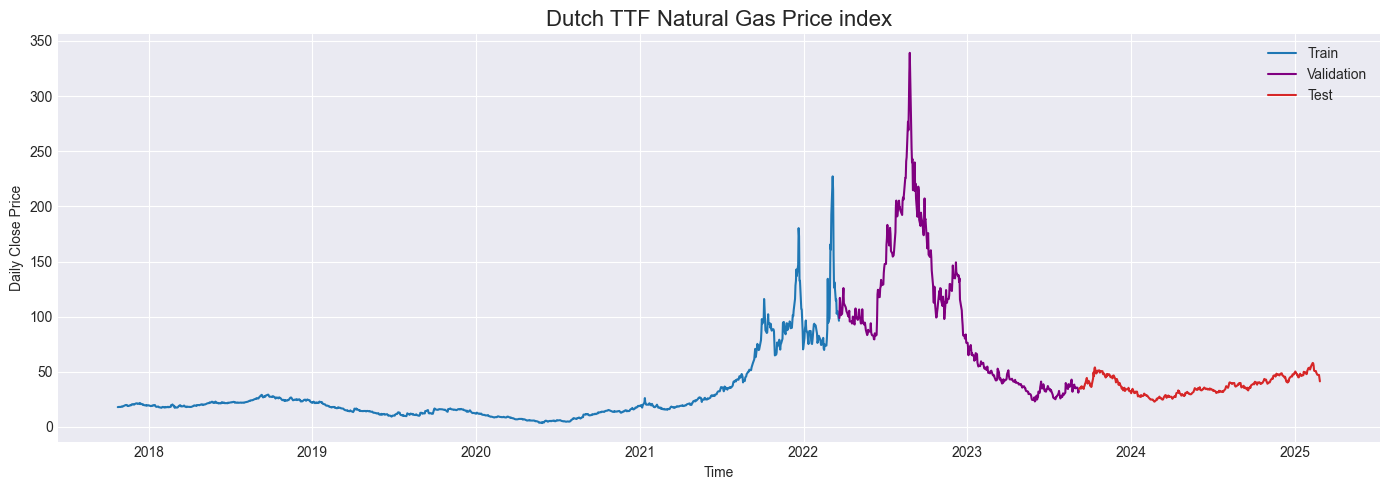

In [68]:
# Train-Validation-Test split plot using matplotlib
plt.figure(figsize=(14, 5))

plt.plot(y_train.index, y_train, label='Train', color='tab:blue')
plt.plot(y_val.index, y_val, label='Validation', color='purple')
plt.plot(y_test.index, y_test, label='Test', color='tab:red')

plt.title("Dutch TTF Natural Gas Price index", fontsize=16)
plt.xlabel("Time")
plt.ylabel("Daily Close Price")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Tidy up exog variables

exog_variables = ['Open',
                  'High',
                  'Low',
                  'daily.returns',
                  'var',
                  'sigma',
                  'resid',
                  'model_Fit1',
                  'model_Fit2',
                  'dayofweek',
                  'dayofmonth',
                  'dayofyear',
                  'weekofyear',
                  'month',
                  'quarter',
                  'year',
                  'week_sin',
                  'week_cos',
                  'month_sin',
                  'month_cos',
                  'OC_change',
                  'HL_range'
                  ]

In [ ]:
window_features = RollingFeatures(stats=["mean", "std", "max", "min"], window_sizes= [21, 21, 21, 21])
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=11368, verbose=-1),
                lags            = 21,
                window_features = window_features,
                differentiation = 1
             )

warnings.simplefilter(action='ignore', category=FutureWarning)

forecaster.fit(y    = y_train
               )

In [70]:
forecaster.predict(10)

2022-03-22     82.096057
2022-03-23     82.236152
2022-03-24     77.147622
2022-03-25     82.940505
2022-03-28     86.365374
2022-03-29     89.981431
2022-03-30     90.255179
2022-03-31     93.127189
2022-04-01     96.614150
2022-04-04    105.305175
Freq: B, Name: pred, dtype: float64

In [76]:
# Backtesting forecaster on validation set with refit windows of 21 and no exog variables

cv = TimeSeriesFold(
        steps              = 21,
        initial_train_size = len(y_train),
        refit              = True,
        differentiation    = 1
)

metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = y[:end_validation],
                            # exog          = data_b.loc[end_train:end_validation, exog_variables],
                            cv            = cv,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False, # Change to False to see less information
                            show_progress = True
                       )

warnings.simplefilter(action='ignore', category=FutureWarning)

metric

100%|██████████| 19/19 [00:01<00:00, 10.46it/s]


mean_absolute_error  mean_absolute_percentage_error  \
0            27.983898                         0.32189   

   root_mean_squared_scaled_error  
0                         7.68902

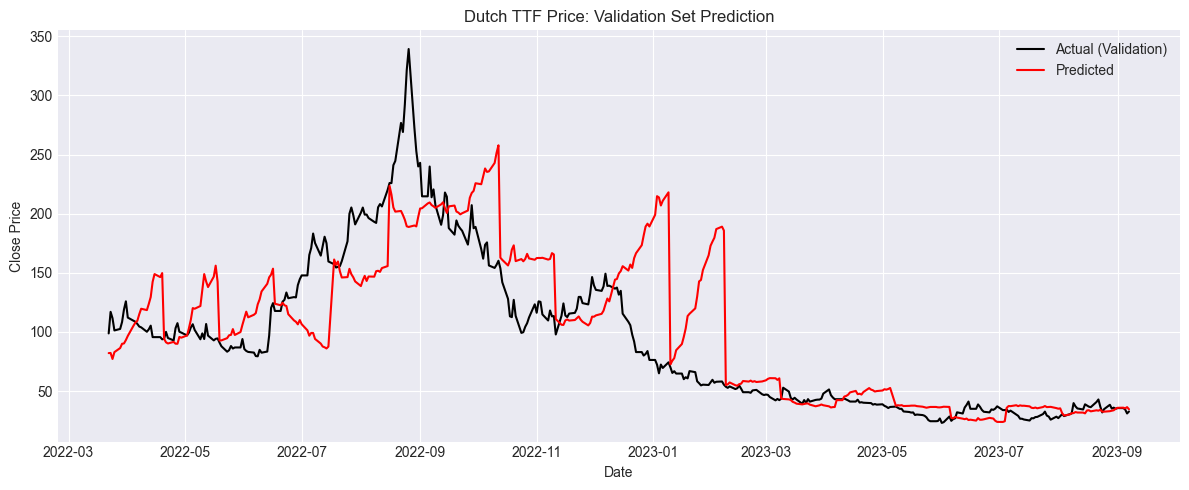

In [ ]:
# Align predictions with y_val index
aligned_val_predictions = predictions[predictions.index.isin(y_val.index)]

plt.figure(figsize=(12, 5))
plt.plot(y_val.index, y_val.values, label='Actual (Validation)', color='black')
plt.plot(aligned_val_predictions.index, aligned_val_predictions['pred'].values, label='Predicted', color='red')
plt.title('Dutch TTF Price: Validation Set Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

In [79]:
# Testing on test set
forecaster.fit(y    = y[:end_validation]
               )

metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = y,
                            cv            = cv,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False, # Change to False to see less information
                            show_progress = True
                       )

warnings.simplefilter('ignore', category=FutureWarning)  

metric

100%|██████████| 37/37 [00:03<00:00, 10.37it/s]


mean_absolute_error  mean_absolute_percentage_error  \
0            15.769698                        0.207941   

   root_mean_squared_scaled_error  
0                        6.065741

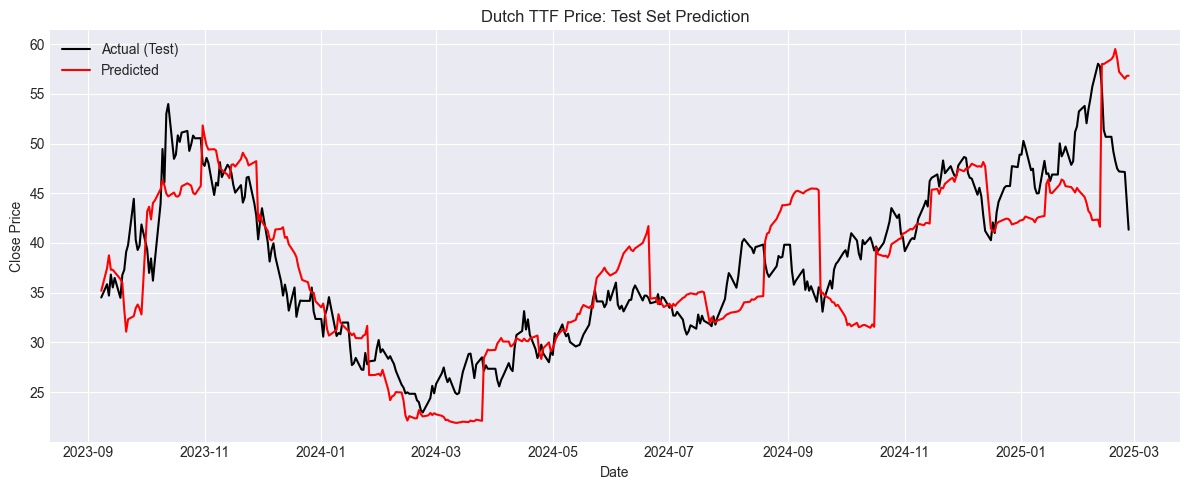

In [80]:
# Align predictions with y_test index
aligned_test_predictions = predictions[predictions.index.isin(y_test.index)]

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual (Test)', color='black')
plt.plot(aligned_test_predictions.index, aligned_test_predictions['pred'].values, label='Predicted', color='red')
plt.title('Dutch TTF Price: Test Set Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

We got results which are a little better on the test set, now we will implement the exogenous variables and see how the algorithm performs

In [ ]:
forecaster.fit(y    = y_train,
               exog = X_train,
               store_in_sample_residuals=True
               )

cv = TimeSeriesFold(
        steps              = 14,
        initial_train_size = len(y_train),
        refit              = True,
        differentiation    = 1
)

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = y.loc[:end_validation],
                            exog          = X.loc[:end_validation],
                            cv            = cv,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False, # Change to False to see less information
                            show_progress = True,
                            interval=[5,95]
                       )

metric

100%|██████████| 28/28 [02:14<00:00,  4.79s/it]


mean_absolute_error  mean_absolute_percentage_error  \
0              8.02143                        0.080844   

   root_mean_squared_scaled_error  
0                        2.339156

Let's check again how the model enhanced with exogenous variables will perform on test set

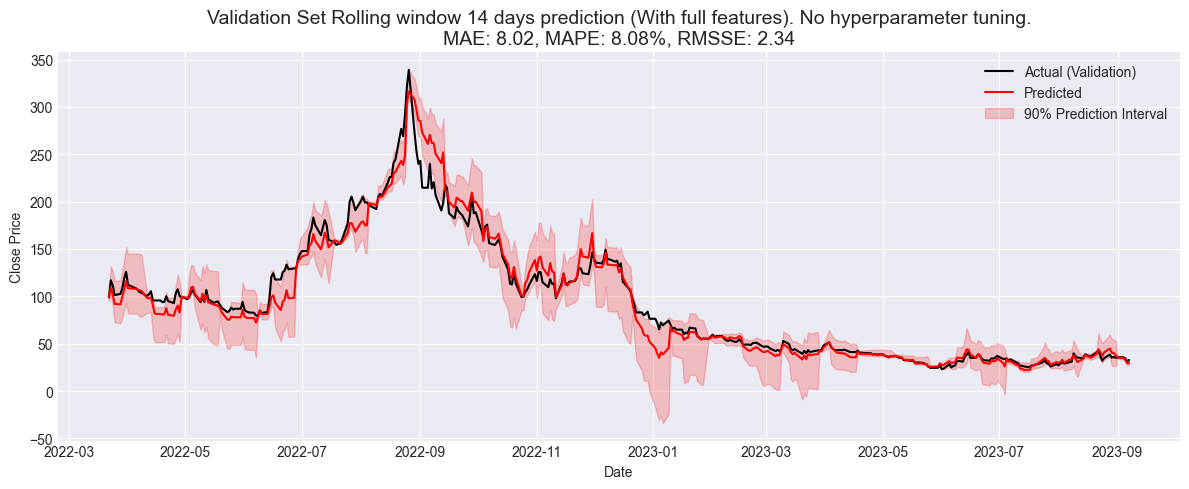

In [160]:
# Plot validation predictions vs actuals with subtitle and metrics using matplotlib
aligned_val_predictions = predictions[predictions.index.isin(y_val.index)]


plt.figure(figsize=(12, 5))
plt.plot(y_val.index, y_val.values, label='Actual (Validation)', color='black')
plt.plot(aligned_val_predictions.index, aligned_val_predictions['pred'].values, label='Predicted', color='red')

plt.fill_between(
    aligned_val_predictions.index,
    aligned_val_predictions['lower_bound'],
    aligned_val_predictions['upper_bound'],
    color='red',
    alpha=0.2,
    label='90% Prediction Interval'
)

mae = metric['mean_absolute_error'].values[0]
mape = metric['mean_absolute_percentage_error'].values[0]
rmsse = metric['root_mean_squared_scaled_error'].values[0]

plt.title(
    "Validation Set Rolling window 14 days prediction (With full features). No hyperparameter tuning.\n"
    f"MAE: {mae:.2f}, MAPE: {mape:.2%}, RMSSE: {rmsse:.2f}",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


In [167]:
forecaster.fit(y    = y_train,
               exog = X_train,
               store_in_sample_residuals=True
               )

predictions = forecaster.predict_interval(
    steps=len(y_val),
    exog=X_val,
    interval=[10, 90]
)

# Plot validation predictions vs actuals with subtitle and metrics using matplotlib
aligned_val_predictions = predictions[predictions.index.isin(y_val.index)]


plt.figure(figsize=(12, 5))
plt.plot(y_val.index, y_val.values, label='Actual (Validation)', color='black')
plt.plot(aligned_val_predictions.index, aligned_val_predictions['pred'].values, label='Predicted', color='red')

# plt.fill_between(
#     aligned_val_predictions.index,
#     aligned_val_predictions['lower_bound'],
#     aligned_val_predictions['upper_bound'],
#     color='red',
#     alpha=0.2,
#     label='90% Prediction Interval'
# )


plt.title(
    "Validation Set prediction (With full features). 0-shot no hyperparameter tuning.\n"
    f"MAE: {mae:.2f}, MAPE: {mape:.2%}, RMSSE: {rmsse:.2f}",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [161]:
forecaster.fit(y    = y.loc[:end_validation],
               exog = X.loc[:end_validation]
               )


warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = y,
                            exog          = X,
                            cv            = cv,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False, # Change to False to see less information
                            show_progress = True,
                            interval=[5,95]
                       )

metric

100%|██████████| 55/55 [03:49<00:00,  4.17s/it]


mean_absolute_error  mean_absolute_percentage_error  \
0             5.116111                        0.071222   

   root_mean_squared_scaled_error  
0                         1.88474

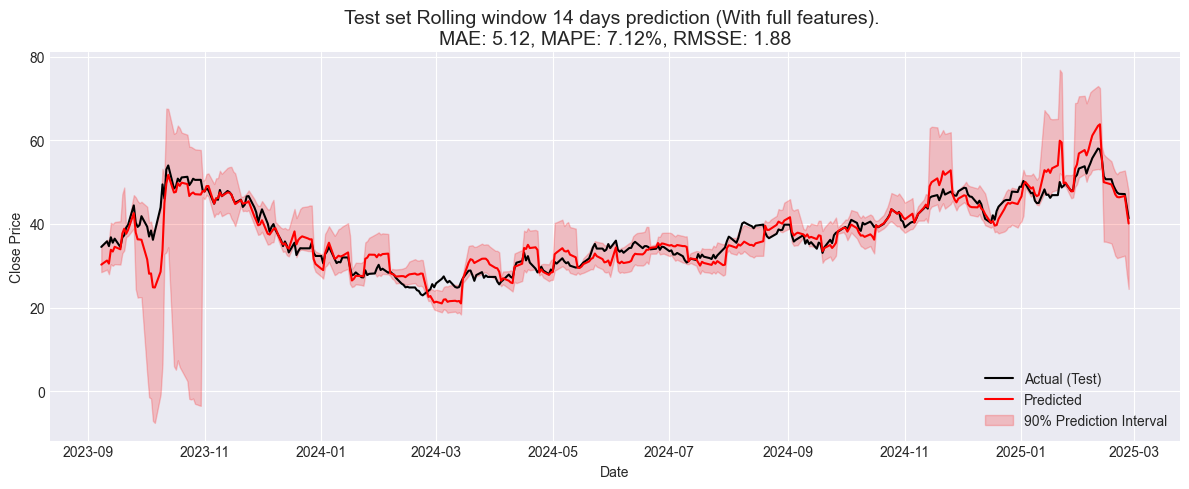

In [163]:
# Align predictions with y_test index
aligned_test_predictions = predictions[predictions.index.isin(y_test.index)]

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual (Test)', color='black')
plt.plot(aligned_test_predictions.index, aligned_test_predictions['pred'].values, label='Predicted', color='red')

plt.fill_between(
    aligned_test_predictions.index,
    aligned_test_predictions['lower_bound'],
    aligned_test_predictions['upper_bound'],
    color='red',
    alpha=0.2,
    label='90% Prediction Interval'
)

mae = metric['mean_absolute_error'].values[0]
mape = metric['mean_absolute_percentage_error'].values[0]
rmsse = metric['root_mean_squared_scaled_error'].values[0]

plt.title(
    "Test set Rolling window 14 days prediction (With full features). \n"
    f"MAE: {mae:.2f}, MAPE: {mape:.2%}, RMSSE: {rmsse:.2f}",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# Now it finda looks overfitted

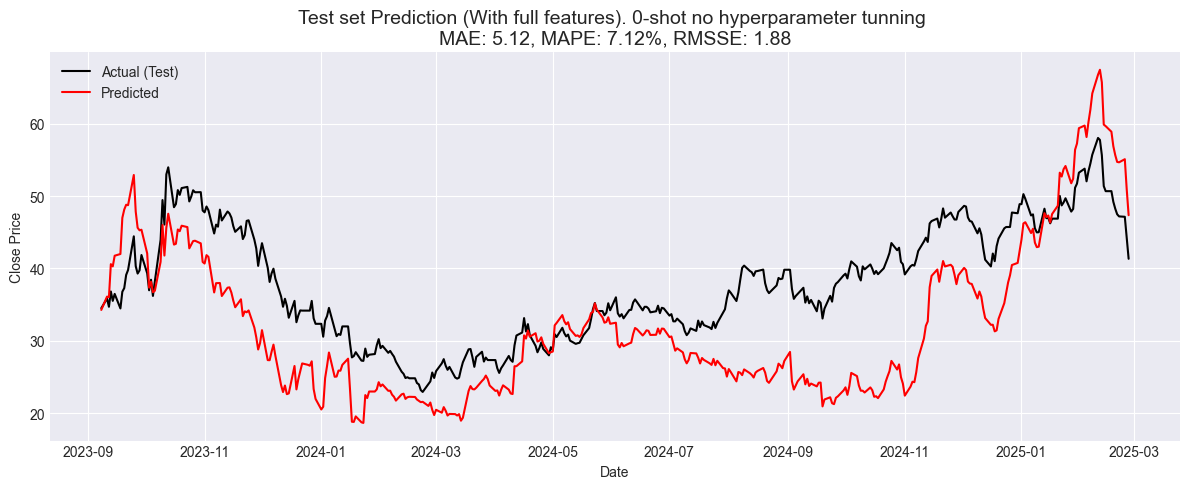

In [170]:
forecaster.fit(y    = y.loc[:end_validation],
               exog = X.loc[:end_validation],
               store_in_sample_residuals=True
               )



predictions = forecaster.predict_interval(
    steps=len(y_test),
    exog=X_test,
    interval=[5, 95]
)


aligned_test_predictions = predictions[predictions.index.isin(y_test.index)]

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual (Test)', color='black')
plt.plot(aligned_test_predictions.index, aligned_test_predictions['pred'].values, label='Predicted', color='red')

# plt.fill_between(
#     aligned_test_predictions.index,
#     aligned_test_predictions['lower_bound'],
#     aligned_test_predictions['upper_bound'],
#     color='red',
#     alpha=0.2,
#     label='90% Prediction Interval'
# )

mae = metric['mean_absolute_error'].values[0]
mape = metric['mean_absolute_percentage_error'].values[0]
rmsse = metric['root_mean_squared_scaled_error'].values[0]

plt.title(
    "Test set Prediction (With full features). 0-shot no hyperparameter tunning \n"
    f"MAE: {mae:.2f}, MAPE: {mape:.2%}, RMSSE: {rmsse:.2f}",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

## Hyperparameter tunning for the optimum model (Train-Validation test)

In [88]:
# Hyperparameters search
# ==============================================================================
# Create forecaster
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=11368, verbose=-1, ),
                lags            = 21,
                window_features = window_features,
                differentiation = 1
            )


# Lags grid
lags_grid = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24]


# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 100, 1200, step=50),
        'max_depth'       : trial.suggest_int('max_depth', 5, 24, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.001, 0.01),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.05),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.05),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

# Folds
cv_search = TimeSeriesFold(
        steps              = 21,
        initial_train_size = len(y_train),
        refit              = True,
        differentiation    = 1
)

results_search, frozen_trial = bayesian_search_forecaster(
                                    forecaster    = forecaster,
                                    y             = y.loc[:end_validation],
                                    exog          = X.loc[:end_validation],
                                    search_space  = search_space,
                                    cv            = cv_search,
                                    metric        = ['mean_absolute_error', 'mean_absolute_percentage_error','root_mean_squared_scaled_error'],
                                    n_trials      = 100,
                                    random_state  = 11368,
                                    return_best   = True,
                                    n_jobs        = 'auto',
                                    verbose       = False,
                                    show_progress = True
                                )
best_params = results_search['params'].iat[0]
best_lags = results_search['lags'].iat[0]

Best trial: 71. Best value: 7.11103: 100%|██████████| 100/100 [07:26<00:00,  4.46s/it]


╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : DataTypeWarning                                                           │
│ Location :                                                                           │
│ c:\Users\const\anaconda3\envs\lightgbm-icbe2025\Lib\site-packages\skforecast\utils\u │
│ tils.py:630                                                                          │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11] 
  Parameters: {'n_estimators': 1100, 'max_depth': 10, 'min_data_in_leaf': 140, 'learning_rate': 0.009534079723222105, 'feature_fraction': 1.0, 'max_bin': 225, 'reg_alpha': 0.25, 'reg_lambda': 1.0}
  Backtesting metric: 7.111034897340352


In [91]:
best_lags
best_params

{'n_estimators': 1100,
 'max_depth': 10,
 'min_data_in_leaf': 140,
 'learning_rate': 0.009534079723222105,
 'feature_fraction': 1.0,
 'max_bin': 225,
 'reg_alpha': 0.25,
 'reg_lambda': 1.0}

We can also check our top performing models

In [89]:
results_search.head(3)

lags  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   

                                              params  mean_absolute_error  \
0  {'n_estimators': 1100, 'max_depth': 10, 'min_d...             7.111035   
1  {'n_estimators': 1050, 'max_depth': 11, 'min_d...             7.244820   
2  {'n_estimators': 1100, 'max_depth': 11, 'min_d...             7.300962   

   mean_absolute_percentage_error  root_mean_squared_scaled_error  \
0                        0.072796                        1.975947   
1                        0.072146                        1.998952   
2                        0.076449                        2.008142   

   n_estimators  max_depth  min_data_in_leaf  learning_rate  feature_fraction  \
0        1100.0       10.0             140.0       0.009534               1.0   
1        1050.0       11.0             137.0       0.009975               1.0   
2        1100.0       11.0             130.0       0.009720               1.0   

   max_bin  reg_alpha  reg_lambda  
0    225.0       0.25         1.0  
1    200.0       0.25         1.0  
2    225.0       0.35         1.0

In [92]:
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

metric, predictions = backtesting_forecaster(
                            forecaster    = forecaster,
                            y             = y,
                            exog          = X,
                            cv            = cv,
                            metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
                            n_jobs        = 'auto',
                            verbose       = False,
                            show_progress = True,
                            interval = [5, 95]
                       )
display(metric)
predictions.head()


100%|██████████| 37/37 [03:31<00:00,  5.70s/it]


mean_absolute_error  mean_absolute_percentage_error  \
0             5.043186                        0.075626   

   root_mean_squared_scaled_error  
0                        1.665832

pred  lower_bound  upper_bound
2022-03-22   99.303415    95.070261   109.007394
2022-03-23  109.043028   101.010182   130.563059
2022-03-24  101.827586    90.526324   123.167082
2022-03-25   91.993627    72.062478   113.354813
2022-03-28   91.437887    71.649612   113.429829

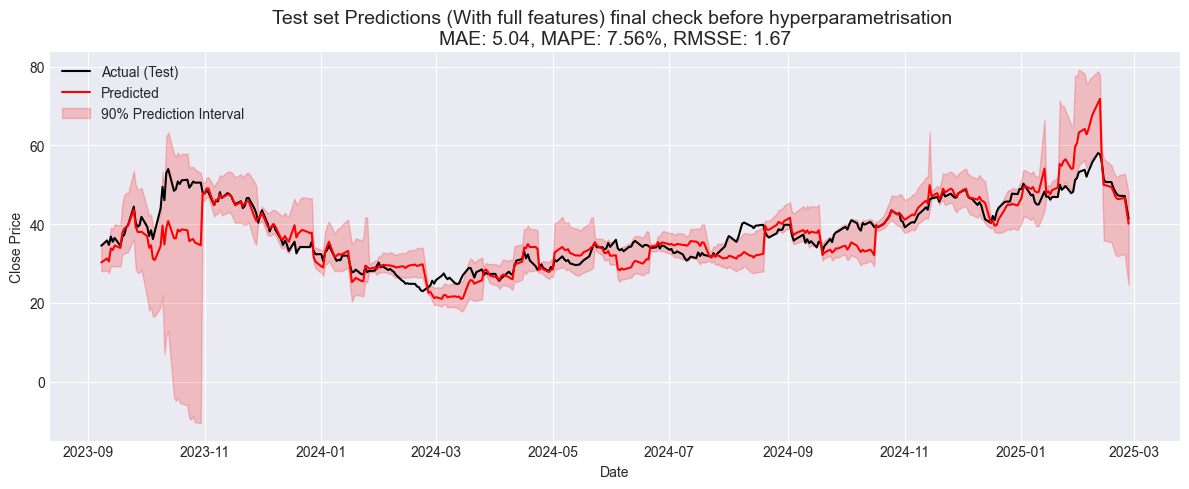

In [96]:
# Align predictions with y_test index
aligned_test_predictions = predictions[predictions.index.isin(y_test.index)]

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual (Test)', color='black')
plt.plot(aligned_test_predictions.index, aligned_test_predictions['pred'].values, label='Predicted', color='red')

# Add confidence intervals
plt.fill_between(
    aligned_test_predictions.index,
    aligned_test_predictions['lower_bound'],
    aligned_test_predictions['upper_bound'],
    color='red',
    alpha=0.2,
    label='90% Prediction Interval'
)

mae = metric['mean_absolute_error'].values[0]
mape = metric['mean_absolute_percentage_error'].values[0]
rmsse = metric['root_mean_squared_scaled_error'].values[0]

plt.title(
    "Test set Predictions (With full features) final check before hyperparametrisation \n"
    f"MAE: {mae:.2f}, MAPE: {mape:.2%}, RMSSE: {rmsse:.2f}",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

# Now it finda looks overfitted

## Building the hyperparametrized model


In [ ]:


forecaster_bp_train = ForecasterRecursive(
    regressor       = LGBMRegressor(random_state=11368, verbose=-1, **best_params),
    lags            = best_lags,
    window_features = window_features,
    differentiation = 1
)

forecaster_bp_train.fit(
    y=y_train,
    exog=X_train,
    store_in_sample_residuals=True
)

# Make predictions on 
val_predictions_bp = forecaster_bp_train.predict_interval(
    steps=len(y_val),
    exog=X_val,
    interval=[5, 95]
)


100%|██████████| 19/19 [00:04<00:00,  3.82it/s]


In [114]:
X_test

Open       High        Low        var     sigma     resid  \
Date                                                                         
2023-09-08  35.090000  36.860001  33.985001  54.251723  7.365577  5.662711   
2023-09-11  36.540001  37.709999  35.605000  51.148988  7.151852  3.879359   
2023-09-12  35.130001  36.575001  34.334999  46.437560  6.814511 -3.055479   
2023-09-13  35.270000  37.974998  35.270000  41.686547  6.456512  5.888729   
2023-09-14  37.450001  37.720001  35.180000  40.609439  6.372554 -3.163678   
...               ...        ...        ...        ...       ...       ...   
2025-02-20  47.349998  48.599998  47.064999  14.031060  3.745806 -1.559106   
2025-02-21  47.650002  48.224998  46.105000  12.875755  3.588280 -0.711014   
2025-02-24  46.134998  47.259998  45.110001  11.648146  3.412938 -0.078859   
2025-02-25  45.435001  45.834999  43.750000  10.528360  3.244743 -6.074319   
2025-02-26  41.335999  41.335999  41.335999  13.966309  3.737152 -6.878125   

            dayofweek  dayofmonth  dayofyear  weekofyear  ...  week_sin  \
Date                                                      ...             
2023-09-08        4.0         8.0      251.0        36.0  ... -0.433884   
2023-09-11        0.0        11.0      254.0        37.0  ...  0.000000   
2023-09-12        1.0        12.0      255.0        37.0  ...  0.781831   
2023-09-13        2.0        13.0      256.0        37.0  ...  0.974928   
2023-09-14        3.0        14.0      257.0        37.0  ...  0.433884   
...               ...         ...        ...         ...  ...       ...   
2025-02-20        3.0        20.0       51.0         8.0  ...  0.433884   
2025-02-21        4.0        21.0       52.0         8.0  ... -0.433884   
2025-02-24        0.0        24.0       55.0         9.0  ...  0.000000   
2025-02-25        1.0        25.0       56.0         9.0  ...  0.781831   
2025-02-26        2.0        26.0       57.0         9.0  ...  0.974928   

            week_cos  month_sin     month_cos  quarter_sin   quarter_cos  \
Date                                                                       
2023-09-08 -0.900969  -1.000000 -1.836970e-16         -1.0 -1.836970e-16   
2023-09-11  1.000000  -1.000000 -1.836970e-16         -1.0 -1.836970e-16   
2023-09-12  0.623490  -1.000000 -1.836970e-16         -1.0 -1.836970e-16   
2023-09-13 -0.222521  -1.000000 -1.836970e-16         -1.0 -1.836970e-16   
2023-09-14 -0.900969  -1.000000 -1.836970e-16         -1.0 -1.836970e-16   
...              ...        ...           ...          ...           ...   
2025-02-20 -0.900969   0.866025  5.000000e-01          1.0  6.123234e-17   
2025-02-21 -0.900969   0.866025  5.000000e-01          1.0  6.123234e-17   
2025-02-24  1.000000   0.866025  5.000000e-01          1.0  6.123234e-17   
2025-02-25  0.623490   0.866025  5.000000e-01          1.0  6.123234e-17   
2025-02-26 -0.222521   0.866025  5.000000e-01          1.0  6.123234e-17   

            OC_change  HL_range  model_Fit1  model_Fit2  
Date                                                     
2023-09-08   0.582001  2.875000       False        True  
2023-09-11   0.692001  2.105000       False        True  
2023-09-12   0.429001  2.240002       False        True  
2023-09-13  -1.547001  2.704998       False        True  
2023-09-14   1.929001  2.540001       False        True  
...               ...       ...         ...         ...  
2025-02-20  -0.144001  1.535000       False        True  
2025-02-21   0.455002  2.119999       False        True  
2025-02-24  -1.009003  2.149998       False        True  
2025-02-25   1.144001  2.084999       False        True  
2025-02-26   0.000000  0.000000       False        True  

[384 rows x 23 columns]

In [119]:

forecaster_bp_test = ForecasterRecursive(
    regressor       = LGBMRegressor(random_state=11368, verbose=-1, **best_params),
    lags            = best_lags,
    window_features = window_features,
    differentiation = 1
)

forecaster_bp_test.fit(
    y=y.loc[:end_validation],
    exog=X.loc[:end_validation],
    store_in_sample_residuals=True
)

# Make predictions on the validation set with confidence intervals
test_predictions_bp = forecaster_bp_test.predict_interval(
    steps=len(y_test),
    exog=X_test,
    interval=[10, 90]
)


MAE: 7.24
MAPE: 19.07%
RMSSE: 1.55


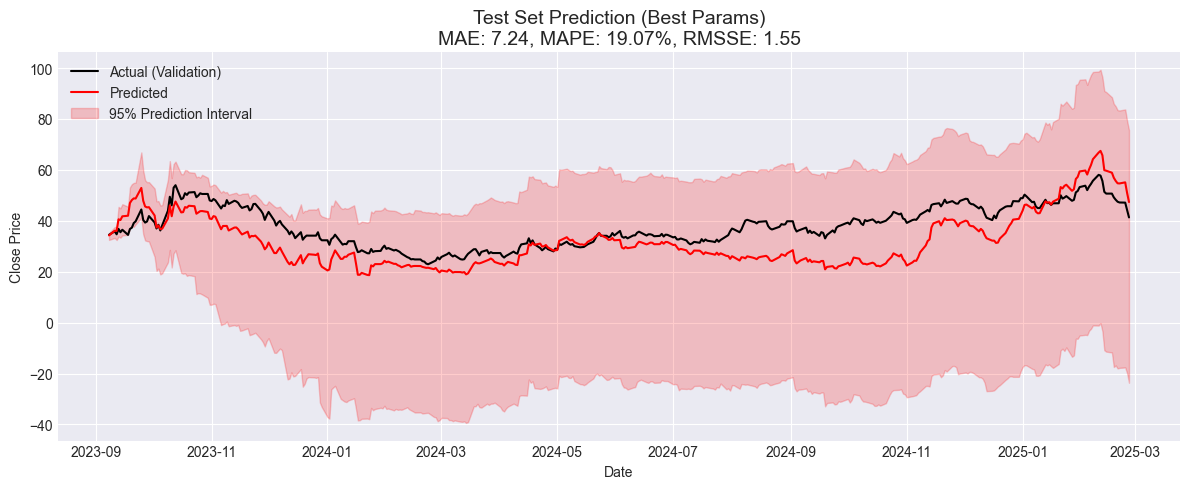

In [120]:
# Align predictions with y_test index
test_predictions_bp.index = y_test.index

# Compute metrics
mae_bp = mean_absolute_error(y_test, test_predictions_bp['pred'])
mape_bp = np.mean(np.abs((y_test - test_predictions_bp['pred']) / y_test))
rmsse_bp = np.sqrt(np.mean((y_test - test_predictions_bp['pred']) ** 2) / np.mean(np.diff(y.loc[:end_validation]) ** 2))

print(f"MAE: {mae_bp:.2f}")
print(f"MAPE: {mape_bp:.2%}")
print(f"RMSSE: {rmsse_bp:.2f}")

# Plot predictions vs actuals with confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual (Validation)', color='black')
plt.plot(test_predictions_bp.index, test_predictions_bp['pred'].values, label='Predicted', color='red')
plt.fill_between(
    test_predictions_bp.index,
    test_predictions_bp['lower_bound'],
    test_predictions_bp['upper_bound'],
    color='red',
    alpha=0.2,
    label='95% Prediction Interval'
)
plt.title(
    "Test Set Prediction (Best Params)\n"
    f"MAE: {mae_bp:.2f}, MAPE: {mape_bp:.2%}, RMSSE: {rmsse_bp:.2f}",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

MAE: 7.24
MAPE: 19.07%
RMSSE: 1.55


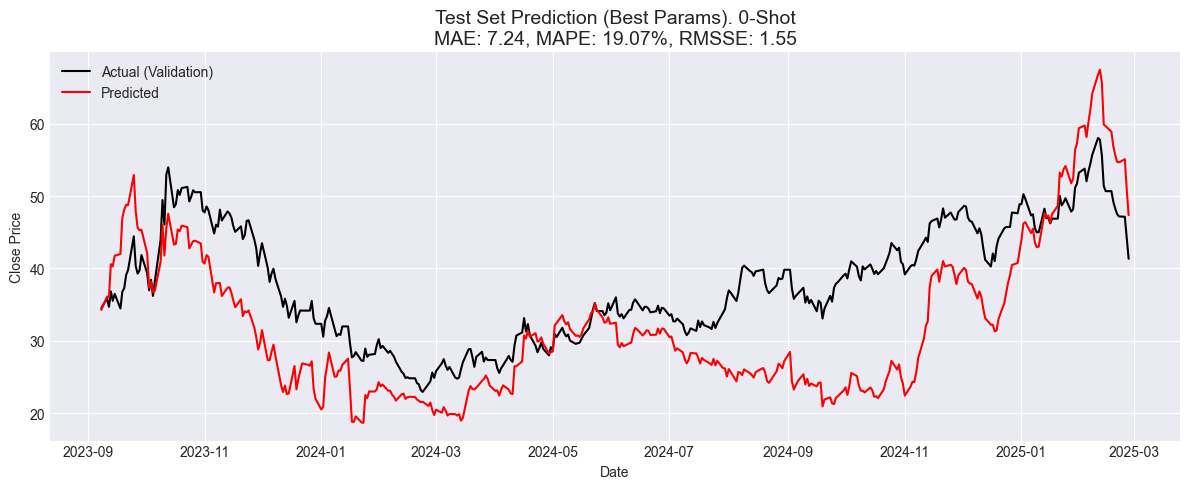

In [123]:
print(f"MAE: {mae_bp:.2f}")
print(f"MAPE: {mape_bp:.2%}")
print(f"RMSSE: {rmsse_bp:.2f}")

# Plot predictions vs actuals with confidence intervals
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual (Validation)', color='black')
plt.plot(test_predictions_bp.index, test_predictions_bp['pred'].values, label='Predicted', color='red')
plt.title(
    "Test Set Prediction (Best Params). 0-Shot\n"
    f"MAE: {mae_bp:.2f}, MAPE: {mape_bp:.2%}, RMSSE: {rmsse_bp:.2f}",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

In [151]:
# Rolling window forecast

tsf = TimeSeriesFold(
        steps              = 14,
        initial_train_size = len(y_train),
        refit              = True,
        differentiation=1
)


metric_bt, predictions_bt = backtesting_forecaster(
    forecaster    =forecaster_bp_test,
    y             =y,
    exog          =X,
    cv            =tsf,
    metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True,
    interval = [5, 95]
    
)

metric_bt

100%|██████████| 55/55 [04:07<00:00,  4.49s/it]


mean_absolute_error  mean_absolute_percentage_error  \
0             5.116111                        0.071222   

   root_mean_squared_scaled_error  
0                         1.88474

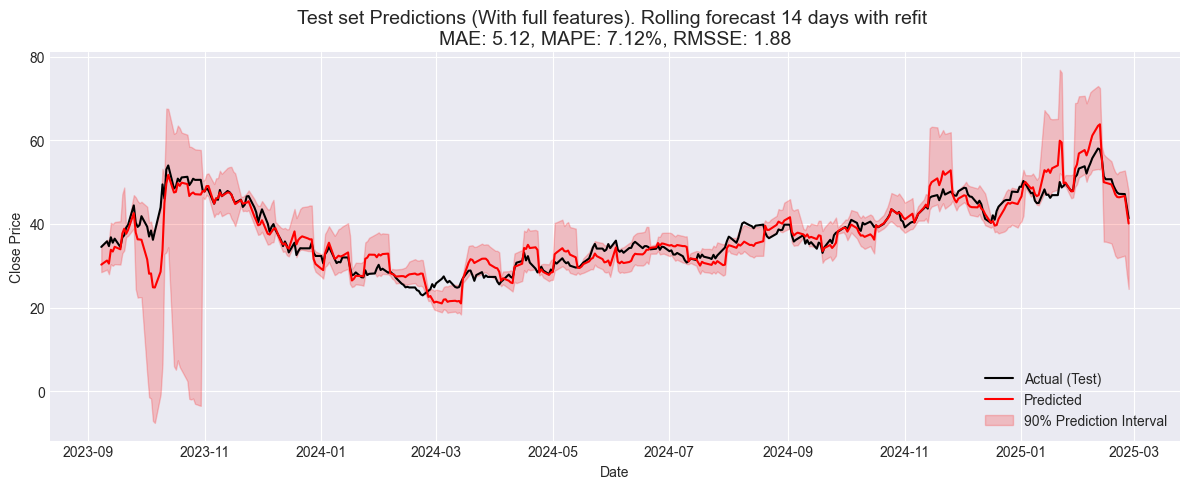

In [152]:
# Align predictions with y_test index after rolling-forecasts routine
aligned_test_predictions = predictions_bt[predictions_bt.index.isin(y_test.index)]

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual (Test)', color='black')
plt.plot(aligned_test_predictions.index, aligned_test_predictions['pred'].values, label='Predicted', color='red')

# Add confidence intervals
plt.fill_between(
    aligned_test_predictions.index,
    aligned_test_predictions['lower_bound'],
    aligned_test_predictions['upper_bound'],
    color='red',
    alpha=0.2,
    label='90% Prediction Interval'
)

mae = metric_bt['mean_absolute_error'].values[0]
mape = metric_bt['mean_absolute_percentage_error'].values[0]
rmsse = metric_bt['root_mean_squared_scaled_error'].values[0]

plt.title(
    "Test set Predictions (With full features). Rolling forecast 14 days with refit \n"
    f"MAE: {mae:.2f}, MAPE: {mape:.2%}, RMSSE: {rmsse:.2f}",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()


100%|██████████| 55/55 [03:45<00:00,  4.10s/it]


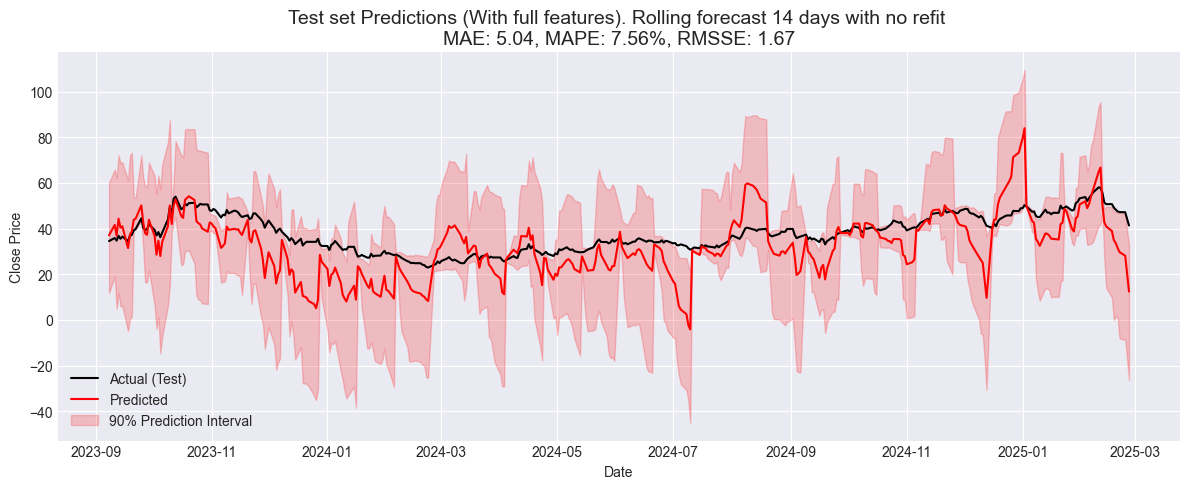

In [ ]:
# Rolling window forecast with no refit

tsf = TimeSeriesFold(
        steps              = 14,
        initial_train_size = len(y_train),
        refit              = False,
        differentiation=1
)


metric_bt, predictions_bt = backtesting_forecaster(
    forecaster    =forecaster_bp_test,
    y             =y,
    exog          =X,
    cv            =tsf,
    metric        = ['mean_absolute_error', 'mean_absolute_percentage_error', 'root_mean_squared_scaled_error'],
    n_jobs        = 'auto',
    verbose       = False,
    show_progress = True,
    interval = [5, 95]
    
)

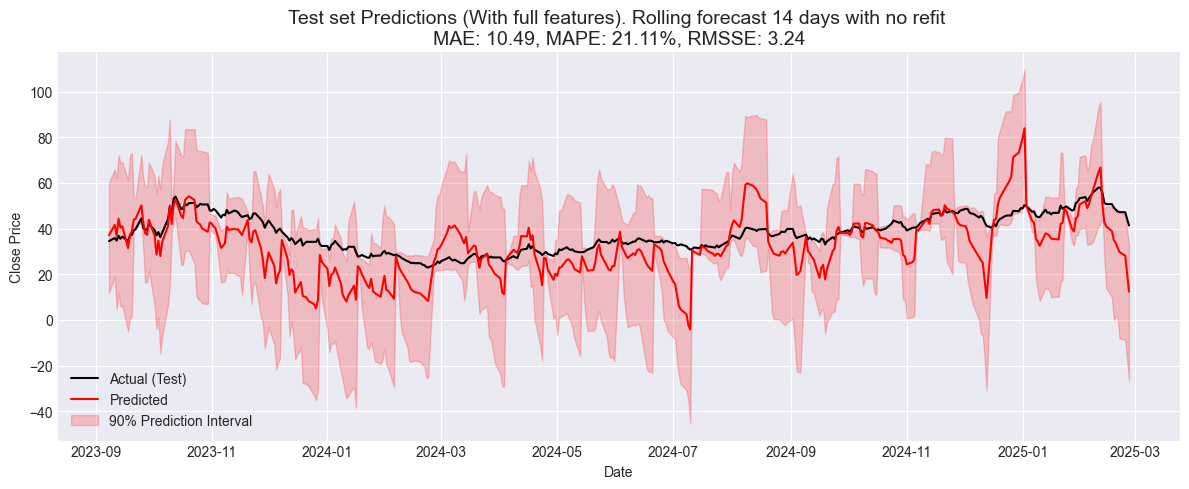

In [150]:
# Align predictions with y_test index after rolling-forecasts routine --- NO REFIT
aligned_test_predictions = predictions_bt[predictions_bt.index.isin(y_test.index)]

plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label='Actual (Test)', color='black')
plt.plot(aligned_test_predictions.index, aligned_test_predictions['pred'].values, label='Predicted', color='red')

# Add confidence intervals
plt.fill_between(
    aligned_test_predictions.index,
    aligned_test_predictions['lower_bound'],
    aligned_test_predictions['upper_bound'],
    color='red',
    alpha=0.2,
    label='90% Prediction Interval'
)

mae = metric_bt['mean_absolute_error'].values[0]
mape = metric_bt['mean_absolute_percentage_error'].values[0]
rmsse = metric_bt['root_mean_squared_scaled_error'].values[0]

plt.title(
    "Test set Predictions (With full features). Rolling forecast 14 days with no refit \n"
    f"MAE: {mae:.2f}, MAPE: {mape:.2%}, RMSSE: {rmsse:.2f}",
    fontsize=14
)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

In [127]:
# Training matrices used by the forecaster to fit the internal regressor
# ==============================================================================
X_train_shap, y_train_shap = forecaster_bp_test.create_train_X_y(
                       y    = y.loc[:end_validation],
                       exog = X.loc[:end_validation]
                   )
display(X_train_shap.head(3))
display(y_train_shap.head(3))



lag_1     lag_2     lag_3     lag_4     lag_5     lag_6  \
Date                                                                     
2017-11-23 -0.139999  0.340000  0.549999 -0.250000  0.185001 -0.320000   
2017-11-24  0.000000 -0.139999  0.340000  0.549999 -0.250000  0.185001   
2017-11-27  0.754999  0.000000 -0.139999  0.340000  0.549999 -0.250000   

               lag_7     lag_8     lag_9    lag_10  ...  week_sin  week_cos  \
Date                                                ...                       
2017-11-23 -0.570002  0.085001  0.305000  0.135000  ...  0.974928 -0.222521   
2017-11-24 -0.320000 -0.570002  0.085001  0.305000  ... -0.433884 -0.900969   
2017-11-27  0.185001 -0.320000 -0.570002  0.085001  ...  0.000000  1.000000   

            month_sin  month_cos   quarter_sin  quarter_cos  OC_change  \
Date                                                                     
2017-11-23       -0.5   0.866025 -2.449294e-16          1.0        0.0   
2017-11-24       -0.5   0.866025 -2.449294e-16          1.0        0.0   
2017-11-27       -0.5   0.866025 -2.449294e-16          1.0        0.0   

            HL_range  model_Fit1  model_Fit2  
Date                                          
2017-11-23       0.0        True       False  
2017-11-24       0.0        True       False  
2017-11-27       0.0        True       False  

[3 rows x 38 columns]

Date
2017-11-23    0.000000
2017-11-24    0.754999
2017-11-27    0.225000
Freq: B, Name: y, dtype: float64

In [128]:
# Create SHAP explainer (for three base models)
# ==============================================================================
explainer = shap.TreeExplainer(forecaster_bp_test.regressor)

# Sample 70% of the data to speed up the calculation
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train_shap.index, size=int(len(X_train_shap)*0.7), replace=False)
X_train_sample = X_train_shap.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)


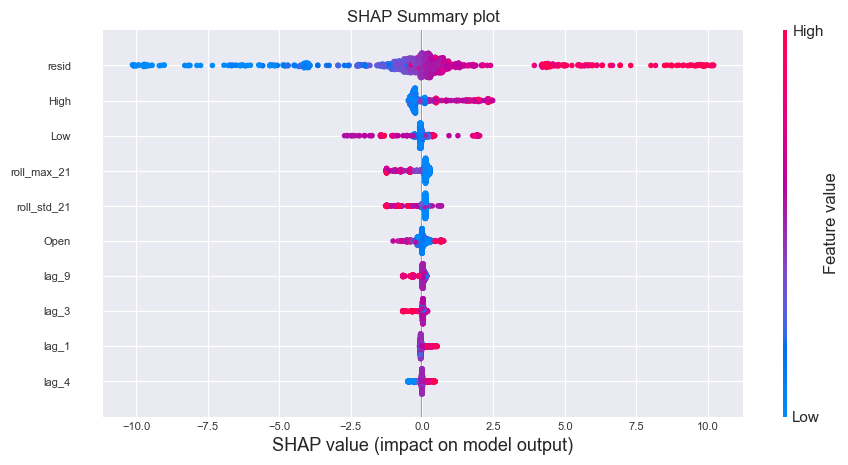

In [129]:
# Shap summary plot (top 10)
# ==============================================================================
shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(10, 4.5)


In [130]:
# Force plot for the first observation
# ==============================================================================
shap.initjs()
force_plot_html = shap.force_plot(explainer.expected_value, shap_values[:,:], X_train_shap.iloc[:,:])

In [131]:
force_plot_html

In [132]:
# Extract feature importance
# ==============================================================================
importance = forecaster_bp_test.get_feature_importances()
importance

feature  importance
20         resid        3329
17           Low         506
16          High         420
15          Open         398
8          lag_9         376
1          lag_2         314
12   roll_std_21         313
0          lag_1         291
11  roll_mean_21         274
2          lag_3         258
22    dayofmonth         250
18           var         249
23     dayofyear         222
13   roll_max_21         220
35      HL_range         201
3          lag_4         193
7          lag_8         169
5          lag_6         138
9         lag_10         133
4          lag_5         110
10        lag_11         109
34     OC_change         103
14   roll_min_21          88
6          lag_7          82
31     month_cos          49
24    weekofyear          31
27          year          19
28      week_sin           8
21     dayofweek           7
36    model_Fit1           2
25         month           2
30     month_sin           2
19         sigma           0
26       quarter           0
29      week_cos           0
32   quarter_sin           0
33   quarter_cos           0
37    model_Fit2           0

## LightGBM regressor tree vizualization

In [ ]:
# Visualisation of the regressor
import graphviz

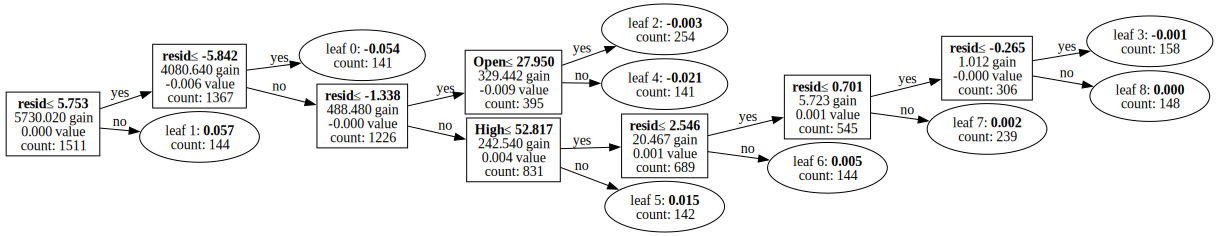

In [134]:

# Create a more detailed tree visualization
lightgbm.create_tree_digraph(forecaster_bp_test.regressor, 
                       tree_index=32,  # visualize first tree
                       show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],
                       name='tree_plot',
                       format='png')

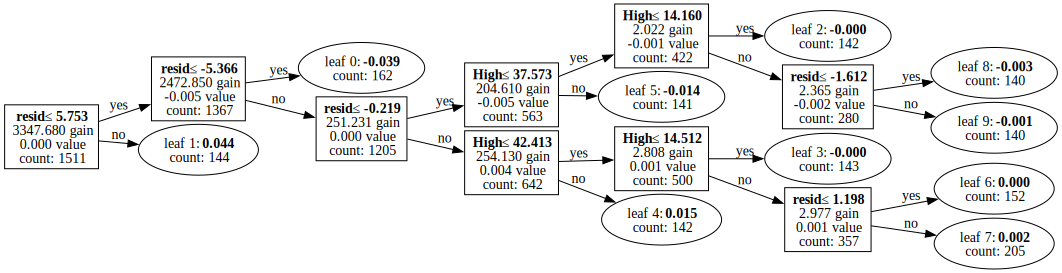

In [135]:
# Create a more detailed tree visualization
lightgbm.create_tree_digraph(forecaster_bp_test.regressor, 
                       tree_index=61,  # visualize first tree
                       show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],
                       name='tree_plot',
                       format='png')

<Axes: title={'center': 'Split value histogram for feature with index 20'}, xlabel='Feature split value', ylabel='Count'>

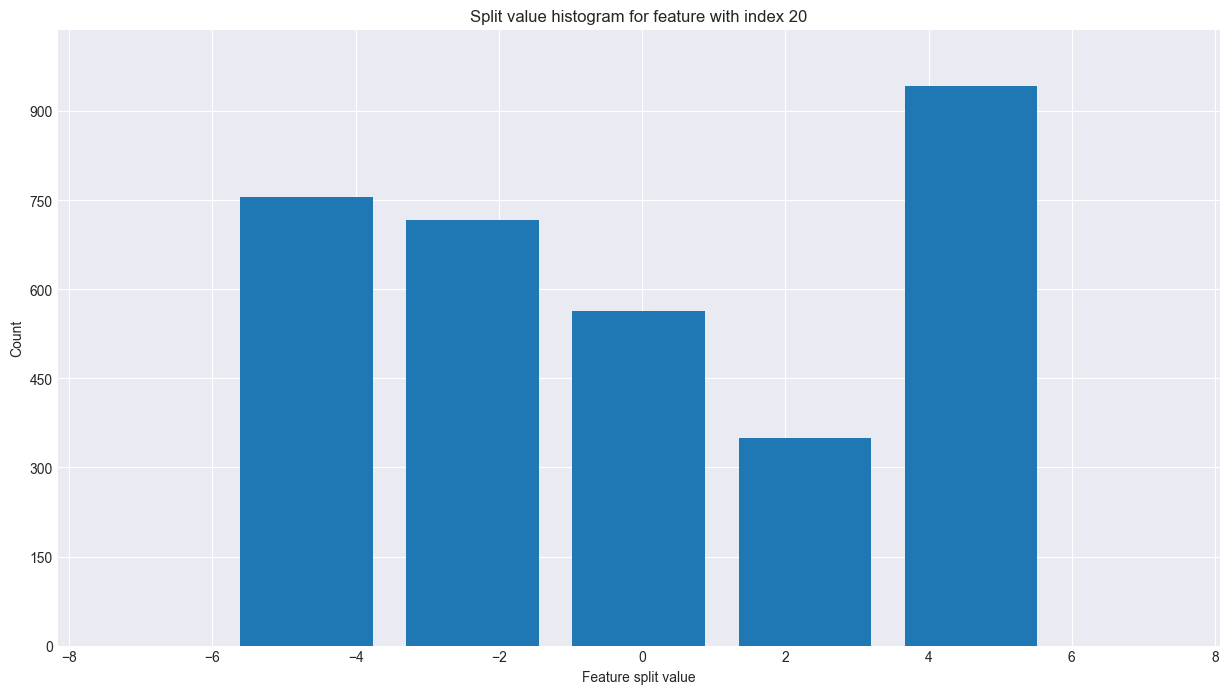

In [156]:
lightgbm.plot_split_value_histogram(
    booster=forecaster_bp_test.regressor,
    feature=20,  # index for 'resid'
    bins=5,
    figsize=(15, 8)
)
